In the previous router, we invoked the model and, if it chose to call a tool, we returned a ToolMessage to the user.

But, what if we simply pass that ToolMessage back to the model?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind ReAct, a general agent architecture.

act - let the model call specific tools
observe - pass the tool output back to the model
reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [11]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add,multiply,divide]

llm=ChatOpenAI(model="gpt-4o")

llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=False)

In [12]:
from langgraph.graph import MessagesState

In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [14]:
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

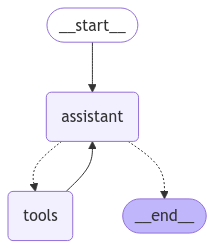

In [15]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


builder=StateGraph(MessagesState)

## Define the node
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools","assistant")

react_graph=builder.compile()

# Show
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [20]:
messages = [HumanMessage(content="Add 10 and 14. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [21]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 10 and 14. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_tvIN1Wda1bfyfkZG6aVD3rSY)
 Call ID: call_tvIN1Wda1bfyfkZG6aVD3rSY
  Args:
    a: 10
    b: 14
================================= Tool Message =================================
Name: add

24
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JbXnUm9EzEpBr5DZNBQDLwhG)
 Call ID: call_JbXnUm9EzEpBr5DZNBQDLwhG
  Args:
    a: 24
    b: 2
================================= Tool Message =================================
Name: multiply

48
================================== Ai Message ==================================
Tool Calls:
  divide (call_YVNuo2oDPBhbwZ94pVmZSMRK)
 Call ID: call_YVNuo2oDPBhbwZ94pVmZSMRK
  Args:
    a: 48
    b: 5
================================= Tool Message =========

### Agents Memory

In [22]:
messages = [HumanMessage(content="Add 14 and 15.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 14 and 15.
================================== Ai Message ==================================
Tool Calls:
  add (call_cTA3cS0Wcmj7zjulUzgxCJW3)
 Call ID: call_cTA3cS0Wcmj7zjulUzgxCJW3
  Args:
    a: 14
    b: 15
================================= Tool Message =================================
Name: add

29
================================== Ai Message ==================================

14 plus 15 equals 29.


In [23]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

I need a specific number or result to multiply by 2. Could you please provide me with the number you would like to multiply?


## MEmeory In Agents Using MemorySaver

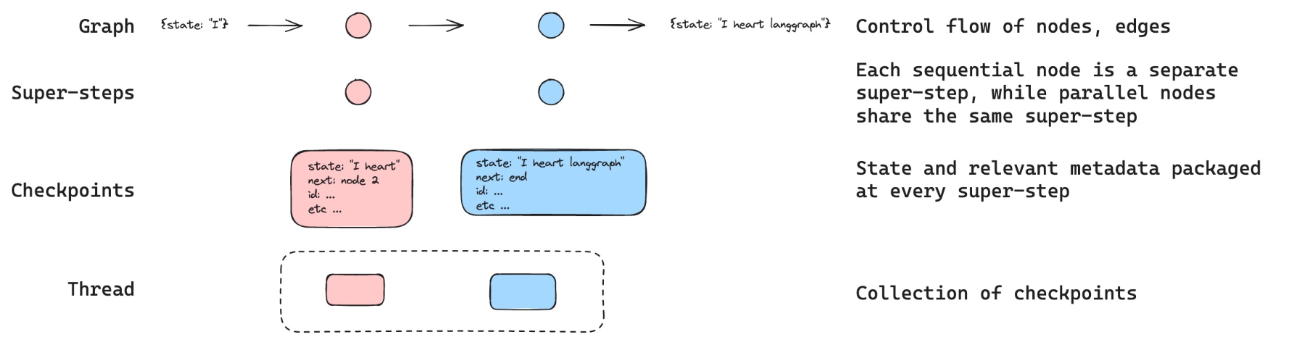

In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

react_graph=builder.compile(checkpointer=memory)

In [25]:
config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Q89VgwgrSpj19HlYZ4oLxM6E)
 Call ID: call_Q89VgwgrSpj19HlYZ4oLxM6E
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [26]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_Q89VgwgrSpj19HlYZ4oLxM6E)
 Call ID: call_Q89VgwgrSpj19HlYZ4oLxM6E
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dJ1Q1nLlI5Z6xrXHSVgk2Bhr)
 Call ID: call_dJ1Q1nLlI5Z6xrXHSVgk2Bhr
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

In [27]:
config1={"configurable":{"thread_id":"2"}}
# Specify an input
messages = [HumanMessage(content="Add 13 and 14.")]

# Run
messages = react_graph.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 13 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_MlZFUiuqM7Xkdl1nNdw3YRXL)
 Call ID: call_MlZFUiuqM7Xkdl1nNdw3YRXL
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.


In [28]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages}, config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 13 and 14.
================================== Ai Message ==================================
Tool Calls:
  add (call_MlZFUiuqM7Xkdl1nNdw3YRXL)
 Call ID: call_MlZFUiuqM7Xkdl1nNdw3YRXL
  Args:
    a: 13
    b: 14
================================= Tool Message =================================
Name: add

27
================================== Ai Message ==================================

The sum of 13 and 14 is 27.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_z3YlGj0PAoYNqchCVty7nAoD)
 Call ID: call_z3YlGj0PAoYNqchCVty7nAoD
  Args:
    a: 27
    b: 2
================================= Tool Message =================================
Name: multiply

54
================================== Ai Message ==================================

The result o